## Get the [Data](https://www.kaggle.com/datasets/brsdincer/garbage-collective-data-for-nature-conservation/data)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"

In [ ]:
!kaggle datasets download -d brsdincer/garbage-collective-data-for-nature-conservation

 96% 233M/243M [00:03<00:00, 81.3MB/s]
100% 243M/243M [00:03<00:00, 75.9MB/s]


In [ ]:
import zipfile

# unzip the data
zip_ref = zipfile.ZipFile("/content/garbage-collective-data-for-nature-conservation.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# inspect the data
!ls /content/Garbage_Collective_Data
garbage_collective_directory = "/content/Garbage_Collective_Data"

battery     brown_glass  clothes      metal  plastic  trash
biological  cardboard	 green_glass  paper  shoes    white_glass


## Get Class Names

In [ ]:
import pathlib
import numpy as np

data_dir = pathlib.Path(garbage_collective_directory)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['battery' 'biological' 'brown_glass' 'cardboard' 'clothes' 'green_glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white_glass']


## Visualize Image

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # setup the target directory
  target_folder = target_dir + "/" + target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # get 1
  print(random_image)

  # read the image and plot it
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape: {img.shape}")
  return img

['cardboard776.jpg']
Image Shape: (160, 241, 3)


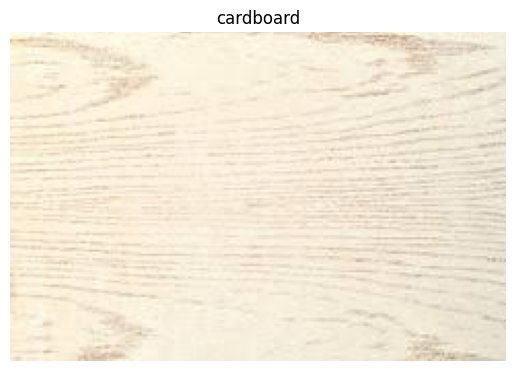

In [ ]:
# visualize
import random

img = view_random_image(target_dir = garbage_collective_directory,
                        target_class = random.choice(class_names))

## Preprocess the data

In [ ]:
# setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(validation_split = 0.2) # set validation data split

# load dataset
train_data = train_datagen.flow_from_directory(garbage_collective_directory,
                                               target_size = IMG_SIZE,
                                               batch_size = 32,
                                               class_mode = "categorical",
                                               subset = "training") # set as training data

test_data = train_datagen.flow_from_directory(garbage_collective_directory,
                                              target_size = IMG_SIZE,
                                              batch_size = 32,
                                              class_mode = "categorical",
                                              shuffle = False,
                                              subset = "validation") # set as test data

Found 12480 images belonging to 12 classes.
Found 3116 images belonging to 12 classes.


## Checkpoint callback

In [ ]:
checkpoint_path = "garbage_model_checkpoint/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

## Create Data Augmentation Layer

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1/255.)
], name = "data_augmentation")

## Setup the base model and Freeze its layers (this will extract features)

In [ ]:
base_model = tf.keras.applications.ResNet50V2(include_top = False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False) # training = False means, model's weights stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_pooling_layer")(x)

outputs = layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

94668760/94668760 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 global_avg_pooling_layer (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 12)                24588     
                                                             

In [ ]:
# compile model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
# fit the model
history = model.fit(train_data,
                    epochs = 10,
                    validation_data = test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [checkpoint_callback])


Epoch 1/10
390/390 [==============================] - 241s 576ms/step - loss: 0.5730 - accuracy: 0.8230 - val_loss: 0.3180 - val_accuracy: 0.8862
Epoch 2/10
390/390 [==============================] - 121s 309ms/step - loss: 0.3402 - accuracy: 0.8906 - val_loss: 0.2630 - val_accuracy: 0.9129
Epoch 3/10
390/390 [==============================] - 97s 247ms/step - loss: 0.2956 - accuracy: 0.9030 - val_loss: 0.2075 - val_accuracy: 0.9375
Epoch 4/10
390/390 [==============================] - 86s 221ms/step - loss: 0.2627 - accuracy: 0.9155 - val_loss: 0.2049 - val_accuracy: 0.9397
Epoch 5/10
390/390 [==============================] - 83s 213ms/step - loss: 0.2483 - accuracy: 0.9203 - val_loss: 0.2844 - val_accuracy: 0.9152
Epoch 6/10
390/390 [==============================] - 75s 192ms/step - loss: 0.2270 - accuracy: 0.9260 - val_loss: 0.1700 - val_accuracy: 0.9375
Epoch 7/10
390/390 [==============================] - 74s 190ms/step - loss: 0.2231 - accuracy: 0.9264 - val_loss: 0.1831 - val_

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.evaluate(test_data)

98/98 [==============================] - 11s 114ms/step - loss: 0.3491 - accuracy: 0.8944


[0.349138081073761, 0.8944159150123596]

## Save Model

In [ ]:
save_dir = "resnet50_garbage_type_detection"
model.save(save_dir)

## Loaded the Saved Model

In [ ]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
loaded_saved_model.evaluate(test_data)

98/98 [==============================] - 11s 99ms/step - loss: 0.3491 - accuracy: 0.8944


[0.349138081073761, 0.8944159150123596]

## Fine-tuning

In [ ]:
# unfreeze all the layers in the base model
base_model.trainable = True

# refrezee every layer except the last five (it is an experiment)
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# recompile the model with lower learning rate (best practice in fine-tuning)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # learning rate lowered by 10x
              metrics = ["accuracy"])

In [ ]:
# check the layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
resnet50v2 True
global_avg_pooling_layer True
output_layer True


In [ ]:
# check the layers in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
history.epoch[-1]

9

## Callback for fine-tuning

In [ ]:
checkpoint_path_fine_tuned = "garbage_model_checkpoint_finetuned/"
checkpoint_callback_fine_tuned = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path_fine_tuned,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [ ]:
# fine-tune for 5 more epochs
fine_tune_epochs = 15 # model has already done 10 epochs (feature extraction), this is the total number of epochs we are after (10 feature extraction + 5 for fine-tune = 15)

# fine tune
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epochs,
                              validation_data = test_data,
                              validation_steps = int(0.15 * len(test_data)),
                              initial_epoch = history.epoch[-1],
                              callbacks = [checkpoint_callback_fine_tuned])

Epoch 10/15
390/390 [==============================] - 67s 159ms/step - loss: 0.1145 - accuracy: 0.9628 - val_loss: 0.2105 - val_accuracy: 0.9241
Epoch 11/15
390/390 [==============================] - 60s 153ms/step - loss: 0.1014 - accuracy: 0.9663 - val_loss: 0.2167 - val_accuracy: 0.9174
Epoch 12/15
390/390 [==============================] - 60s 153ms/step - loss: 0.0939 - accuracy: 0.9688 - val_loss: 0.2664 - val_accuracy: 0.9062
Epoch 13/15
390/390 [==============================] - 57s 147ms/step - loss: 0.0930 - accuracy: 0.9689 - val_loss: 0.2352 - val_accuracy: 0.9152
Epoch 14/15
390/390 [==============================] - 58s 148ms/step - loss: 0.0754 - accuracy: 0.9761 - val_loss: 0.2040 - val_accuracy: 0.9330
Epoch 15/15
390/390 [==============================] - 60s 153ms/step - loss: 0.0753 - accuracy: 0.9751 - val_loss: 0.1282 - val_accuracy: 0.9576


In [ ]:
# evaluate the fine tuned model
fine_tune_results = model.evaluate(test_data)
fine_tune_results

98/98 [==============================] - 11s 109ms/step - loss: 0.3187 - accuracy: 0.9175


[0.31866899132728577, 0.9175224900245667]

In [ ]:
model.load_weights(checkpoint_path_fine_tuned)
model.evaluate(test_data)

98/98 [==============================] - 10s 98ms/step - loss: 0.3187 - accuracy: 0.9175


[0.31866899132728577, 0.9175224900245667]